In [ ]:
import os
import sys


# sys.path.insert(0,r'C:\Users\coren\Documents\PhD\Code\AMFtrack')

import pandas as pd
from amftrack.util.sys import (
    update_plate_info,
    get_current_folders,
)

from datetime import datetime, timedelta
from amftrack.util.dbx import upload_folders
from time import time_ns

directory_origin = r"/mnt/sun-temp/TEMP/PRINCE_syncing/"
dir_drop = "DATA/PRINCE"
# suffix_data_info = str(time_ns())
# update_plate_info(directory_origin, local=True,strong_constraint=False,suffix_data_info = suffix_data_info)
# all_folders_origin = get_current_folders(directory_origin, local=True,suffix_data_info = suffix_data_info)

all_folders_origin["date_datetime"] = pd.to_datetime(
    all_folders_origin["date"].astype(str), format="%d.%m.%Y, %H:%M:"
)
selection = (datetime.now() - all_folders_origin["date_datetime"]) <= timedelta(days=2)
current_prince = all_folders_origin.loc[selection]
plates_in_prince = current_prince["unique_id"].unique()
old_folders = all_folders_origin.loc[
    all_folders_origin["unique_id"].isin(plates_in_prince) == False
]

In [19]:
old_folders

,total_path,Plate,PrincePos,root,strain,medium,split,Pbait,CrossDate,Temperature,...,/Analysis/transform_corrupt.mat,/Analysis/skeleton_realigned_compressed.mat,/Analysis/nx_graph_pruned.p,/Analysis/nx_graph_pruned_width.p,/Analysis/nx_graph_pruned_labeled.p,date,folder,unique_id,datetime,date_datetime
2,/mnt/sun-temp/TEMP/PRINCE_syncing/20220617_005...,19,2,'Carrot','Agg','001P100N100C','Y','-',20220525,25,...,False,False,False,False,False,"17.06.2022, 00:52:",20220617_0052_Plate02,19_20220525,2022-06-17 00:52:00,2022-06-17 00:52:00
9,/mnt/sun-temp/TEMP/PRINCE_syncing/20220527_113...,19,2,'Carrot','Agg','001P100N100C','Y','-',20220525,25,...,False,False,False,False,False,"27.05.2022, 11:35:",20220527_1135_Plate02,19_20220525,2022-05-27 11:35:00,2022-05-27 11:35:00
21,/mnt/sun-temp/TEMP/PRINCE_syncing/20220703_012...,512,7,'None','C2','Myr','Y','-',20220623,25,...,False,False,False,False,False,"03.07.2022, 01:28:",20220703_0128_Plate07,512_20220623,2022-07-03 01:28:00,2022-07-03 01:28:00
23,/mnt/sun-temp/TEMP/PRINCE_syncing/20220629_163...,28focus,9,'Carrot','Agg','001P100N100C','Y','-',20220603,25,...,False,False,False,False,False,"29.06.2022, 16:34:",20220629_1634_Plate22,28focus_20220603,2022-06-29 16:34:00,2022-06-29 16:34:00
24,/mnt/sun-temp/TEMP/PRINCE_syncing/20220622_153...,19,2,'Carrot','Agg','001P100N100C','Y','-',20220525,25,...,False,False,False,False,False,"22.06.2022, 15:32:",20220622_1532_Plate02,19_20220525,2022-06-22 15:32:00,2022-06-22 15:32:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4465,/mnt/sun-temp/TEMP/PRINCE_syncing/20220610_094...,19,2,'Carrot','Agg','001P100N100C','Y','-',20220525,25,...,False,False,False,False,False,"10.06.2022, 09:40:",20220610_0940_Plate02,19_20220525,2022-06-10 09:40:00,2022-06-10 09:40:00
4467,/mnt/sun-temp/TEMP/PRINCE_syncing/20220603_170...,19,2,'Carrot','Agg','001P100N100C','Y','-',20220525,25,...,False,False,False,False,False,"03.06.2022, 17:07:",20220603_1707_Plate02,19_20220525,2022-06-03 17:07:00,2022-06-03 17:07:00
4468,/mnt/sun-temp/TEMP/PRINCE_syncing/20220613_052...,19,2,'Carrot','Agg','001P100N100C','Y','-',20220525,25,...,False,False,False,False,False,"13.06.2022, 05:28:",20220613_0528_Plate02,19_20220525,2022-06-13 05:28:00,2022-06-13 05:28:00
4469,/mnt/sun-temp/TEMP/PRINCE_syncing/20220617_125...,19,2,'Carrot','Agg','001P100N100C','Y','-',20220525,25,...,False,False,False,False,False,"17.06.2022, 12:52:",20220617_1252_Plate02,19_20220525,2022-06-17 12:52:00,2022-06-17 12:52:00


In [57]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
import os
import sys

sys.path.insert(0, r"/home/ipausers/bisot/pycode/MscThesis")
# sys.path.insert(0,r'C:\Users\coren\Documents\PhD\Code\AMFtrack')

import pandas as pd
from amftrack.util.sys import (
    get_dates_datetime,
    get_dirname,
    get_data_info,
    update_plate_info,
    get_current_folders,
    get_folders_by_plate_id,
)

import pandas as pd
import ast
from scipy import sparse
from datetime import datetime
from amftrack.pipeline.functions.image_processing.node_id import orient
import scipy.io as sio
import cv2
import imageio
import numpy as np
from skimage.filters import frangi
from skimage import filters
import scipy.sparse
import os
from time import time
from skimage.feature import hessian_matrix_det
from amftrack.pipeline.functions.image_processing.extract_graph import (
    from_sparse_to_graph,
    generate_nx_graph,
)
from amftrack.pipeline.functions.image_processing.extract_skel import (
    extract_skel_tip_ext,
    bowler_hat,
    extract_skel_bowler_hat,
)
import matplotlib.pyplot as plt
import cv2 as cv
from tqdm.autonotebook import tqdm
from time import time_ns
import subprocess
from cv2_rolling_ball import subtract_background_rolling_ball

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
filename = "imtest"
place_save = "/data/temp"
place_save_final = r"/mnt/sun-temp/TEMP/coco_analysis"

path_anis = os.getenv("HOME") + "/anis_filter/anifilters/bin/ani2D"
list_args = [0.1, 7, 0.9, 10, 50]


def extract_skel(image, args_bowl, name, bowl=True):
    if bowl:
        img_back_removed, background = subtract_background_rolling_ball(
            image.copy(),
            20,
            light_background=True,
            use_paraboloid=True,
            do_presmooth=True,
        )
        params = [10]
    else:
        img_back_removed = image
        params = [30]
    bowled = bowler_hat(-img_back_removed, 16, params)
    to_smooth = bowled * 255
    # to_smooth = 255-im
    imtransformed_path = f"{place_save}/{filename}.tif"
    imageio.imsave(imtransformed_path, to_smooth.astype(np.uint8))
    args = args_bowl
    command = [path_anis, imtransformed_path] + args
    command = [str(elem) for elem in command]
    process = subprocess.run(command, cwd=place_save)
    foldname = (
        f"{filename}_ani-K{int(args[0]*10)}s{args[1]}g{int(args[2]*10)}itD{args[3]}"
    )
    imname = foldname + f"/{foldname}it{args[4]}.tif"
    path_modif = place_save + "/" + imname
    im2 = imageio.imread(path_modif)
    percentile_low = 97 if bowl else 92
    low = np.percentile(im2, percentile_low)
    high = np.percentile(im2, 99.8)
    # transformed = -img+255
    transformed = im2

    hyst = filters.apply_hysteresis_threshold(transformed, low, high)
    kernel = np.ones((3, 3), np.uint8)
    dilation = cv.dilate(hyst.astype(np.uint8) * 255, kernel, iterations=1)
    for i in range(3):
        dilation = cv.erode(dilation.astype(np.uint8) * 255, kernel, iterations=1)
        dilation = cv.dilate(dilation.astype(np.uint8) * 255, kernel, iterations=1)
    dilated = dilation > 0
    nb_components, output, stats, centroids = cv.connectedComponentsWithStats(
        dilated.astype(np.uint8), connectivity=8
    )
    sizes = stats[1:, -1]
    nb_components = nb_components - 1
    min_size = 4000
    img_f = np.zeros((dilated.shape))
    for i in range(0, nb_components):
        if sizes[i] >= min_size:
            img_f[output == i + 1] = 1
    skeletonized = cv.ximgproc.thinning(np.array(255 * img_f, dtype=np.uint8))
    imtransformed_path = f"{place_save_final}/{name}_img_back_removed.tif"
    imageio.imsave(imtransformed_path, img_back_removed.astype(np.uint8))
    imtransformed_path = f"{place_save_final}/{name}_im_smoothed.tif"
    imageio.imsave(imtransformed_path, im2.astype(np.uint8))
    imtransformed_path = f"{place_save_final}/{name}_im_segmented.tif"
    imageio.imsave(imtransformed_path, dilated.astype(np.uint8) * 255)

In [43]:
directory = r"/mnt/sun-temp/TEMP/PRINCE_analysis/"
update_plate_info(directory)

all_folders = get_current_folders(directory)

analysed:   0%|          | 0/162 [00:00<?, ?it/s]

In [44]:
folders = all_folders.loc[all_folders["folder"] == "20220407_0017_Plate01"]

In [47]:
i = 0
run_info = folders
folder_list = list(run_info["folder"])
folder_list.sort()
directory_name = folder_list[i]
path_snap = directory + directory_name
path_tile = path_snap + "/Img/TileConfiguration.txt.registered"
try:
    tileconfig = pd.read_table(
        path_tile,
        sep=";",
        skiprows=4,
        header=None,
        converters={2: ast.literal_eval},
        skipinitialspace=True,
    )
except:
    print("error_name")
    path_tile = path_snap + "/Img/TileConfiguration.registered.txt"
    tileconfig = pd.read_table(
        path_tile,
        sep=";",
        skiprows=4,
        header=None,
        converters={2: ast.literal_eval},
        skipinitialspace=True,
    )
dirName = path_snap + "/Analysis"
shape = (3000, 4096)
try:
    os.mkdir(path_snap + "/Analysis")
    print("Directory ", dirName, " Created ")
except FileExistsError:
    print("Directory ", dirName, " already exists")
t = time()
xs = [c[0] for c in tileconfig[2]]
ys = [c[1] for c in tileconfig[2]]
dim = (int(np.max(ys) - np.min(ys)) + 4096, int(np.max(xs) - np.min(xs)) + 4096)
ims = []
skel = np.zeros(dim, dtype=np.uint8)

Directory  /mnt/sun-temp/TEMP/PRINCE_analysis/20220407_0017_Plate01/Analysis  already exists


In [48]:
j = 44
for index, name in enumerate(tileconfig[0][j : j + 1]):
    imname = "/Img/" + name.split("/")[-1]
    path_im = directory + directory_name + imname
    im = imageio.imread(path_im)

In [68]:
# extract_skel(im,list_args,'test')
extract_skel(im, list_args, "test2", False)

image : /data/temp/imtest.tif
mkdir -p imtest_ani-K1s7g9itD10
Image 2D
Computing diffusion tensor
0
1
2
3
4
5
6
7
8
9
update diffusion tensor
10
11
12
13
14
15
16
17
18
19
update diffusion tensor
20
save image
21
22
23
24
25
26
27
28
29
update diffusion tensor
30
31
32
33
34
35
36
37
38
39
update diffusion tensor
40
save image
41
42
43
44
45
46
47
48
49
time elapsed : 28.8667 seconds
  = ~ 0.481112 minutes


In [ ]:
for j in [41, 42, 43, 44]:
    for index, name in enumerate(tileconfig[0][j : j + 1]):
        imname = "/Img/" + name.split("/")[-1]
        path_im = directory + directory_name + imname
        im = imageio.imread(path_im)
    extract_skel(im, list_args, f"test2_{j}", False)
    extract_skel(im, list_args, f"test_{j}")

image : /data/temp/imtest.tif
mkdir -p imtest_ani-K1s7g9itD10
Image 2D
Computing diffusion tensor
0
1
2
3
4
5
6
7
8
9
update diffusion tensor
10
11
12
13
14
15
16
17
18
19
update diffusion tensor
20
save image
21
22
23
24
25
26
27
28
29
update diffusion tensor
30
31
32
33
34
35
36
37
38
39
update diffusion tensor
40
save image
41
42
43
44
45
46
47
48
49
time elapsed : 26.1395 seconds
  = ~ 0.435659 minutes
image : /data/temp/imtest.tif
mkdir -p imtest_ani-K1s7g9itD10
Image 2D
Computing diffusion tensor
0
1
2
3
4
5
6
7
8
9
update diffusion tensor
10
11
12
13
14
15
16
17
18
19
update diffusion tensor
20
save image
21
22
23
24
25
26
27
28
29
update diffusion tensor
30
31
32
33
34
35
36
37
38
39
update diffusion tensor
40
save image
41
42
43
44
45
46
47
48
49
time elapsed : 31.2984 seconds
  = ~ 0.521639 minutes
image : /data/temp/imtest.tif
mkdir -p imtest_ani-K1s7g9itD10
Image 2D
Computing diffusion tensor
0
1
2
3
4
5
6
7
8
9
update diffusion tensor
10
11
12
13
14
15
16
17
18
19
update d

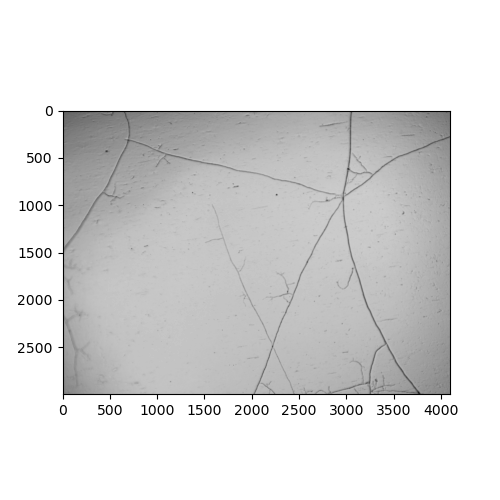

In [30]:
fig = plt.figure(figsize=(5, 5))
ax2 = fig.add_subplot(111)
ax2.imshow(im, cmap="gray")

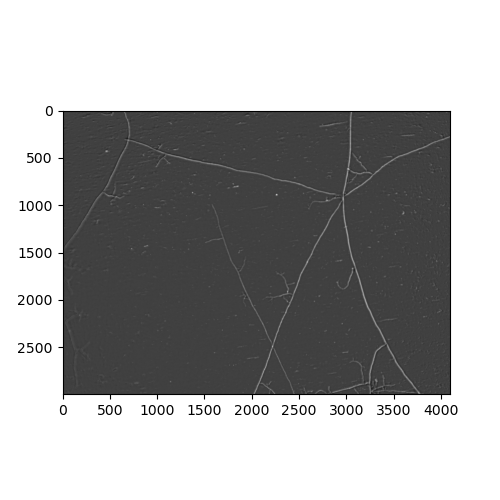

In [31]:
from skimage.filters import threshold_local

to_transform = -im
background = threshold_local(
    to_transform, 51, offset=np.percentile(im, 1), method="median"
)
bg_corrected = to_transform - background
img_back_removed = bg_corrected
fig = plt.figure(figsize=(5, 5))
ax2 = fig.add_subplot(111)
ax2.imshow(bg_corrected, cmap="gray")

In [ ]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
from cv2_rolling_ball import subtract_background_rolling_ball


def plot_result(image, background):
    fig, ax = plt.subplots(nrows=1, ncols=3)

    ax[0].imshow(image, cmap="gray")
    ax[0].set_title("Original image")
    ax[0].axis("off")

    ax[1].imshow(background, cmap="gray")
    ax[1].set_title("Background")
    ax[1].axis("off")

    ax[2].imshow(image - background, cmap="gray")
    ax[2].set_title("Result")
    ax[2].axis("off")

    fig.tight_layout()


image = im.copy()

img_back_removed, background = subtract_background_rolling_ball(
    image, 20, light_background=True, use_paraboloid=True, do_presmooth=True
)

fig = plt.figure(figsize=(5, 5))
ax2 = fig.add_subplot(111)
ax2.imshow(-img_back_removed, cmap="gray")

In [ ]:
fig = plt.figure(figsize=(5, 5))
ax2 = fig.add_subplot(111)
ax2.imshow(background, cmap="gray")

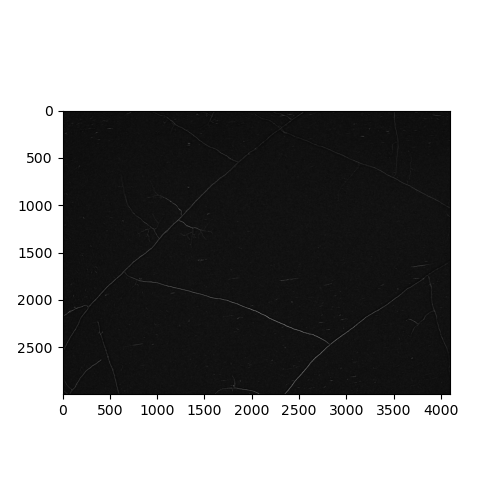

In [14]:
params = [10]
bowled = bowler_hat(-img_back_removed, 12, params)
fig = plt.figure(figsize=(5, 5))
ax2 = fig.add_subplot(111)
ax2.imshow(255 * bowled, cmap="gray")

In [41]:
filename = "imtest"
place_save = "/home/ipausers/bisot/temp"
# to_smooth = (bowled*255)
to_smooth = bowled * 255
imtransformed_path = f"{place_save}/{filename}.tif"
imageio.imsave(imtransformed_path, to_smooth.astype(np.uint8))
# imageio.imsave(imtransformed_path,frangised.astype(np.uint8))

In [42]:
path_anis = os.getenv("HOME") + "/anis_filter/anifilters/bin/ani2D"

In [43]:
list_args = [[0.1, 7, 0.9, 10, 50]]
for args in list_args:
    command = [path_anis, imtransformed_path] + args
    command = [str(elem) for elem in command]
    print(r" ".join(command))
    process = subprocess.run(command, cwd=place_save)

/home/ipausers/bisot/anis_filter/anifilters/bin/ani2D /home/ipausers/bisot/temp/imtest.tif 0.1 7 0.9 10 50
image : /home/ipausers/bisot/temp/imtest.tif
mkdir -p imtest_ani-K1s7g9itD10
Image 2D
Computing diffusion tensor
0
1
2
3
4
5
6
7
8
9
update diffusion tensor
10
11
12
13
14
15
16
17
18
19
update diffusion tensor
20
save image
21
22
23
24
25
26
27
28
29
update diffusion tensor
30
31
32
33
34
35
36
37
38
39
update diffusion tensor
40
save image
41
42
43
44
45
46
47
48
49
time elapsed : 26.9035 seconds
  = ~ 0.448391 minutes


[0.1, 7, 0.9, 10, 50]


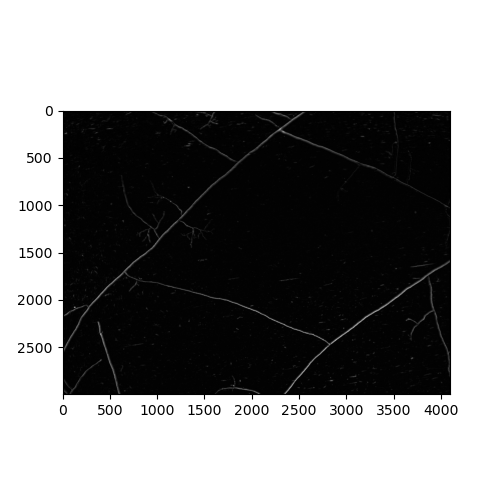

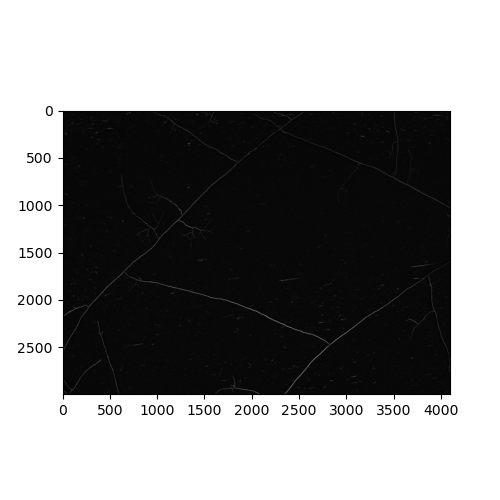

In [44]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.imshow(-img + 255, cmap="gray")
for args in list_args:
    foldname = (
        f"{filename}_ani-K{int(args[0]*10)}s{args[1]}g{int(args[2]*10)}itD{args[3]}"
    )
    imname = foldname + f"/{foldname}it{args[4]}.tif"
    path_modif = place_save + "/" + imname
    im2 = imageio.imread(path_modif)
    print(args)
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)
    ax.imshow(im2, cmap="gray")
    # bowled = bowler_hat(im2,12,[10])
    # fig = plt.figure(figsize=(5,5))
    # ax = fig.add_subplot(111)
    # ax.imshow(bowled*255,cmap='gray')
    break

In [153]:
-img + 255

Array([[2, 1, 2, ..., 0, 1, 1],
       [1, 2, 3, ..., 1, 1, 0],
       [0, 1, 3, ..., 0, 1, 0],
       ...,
       [1, 1, 1, ..., 5, 5, 5],
       [1, 1, 0, ..., 6, 6, 6],
       [1, 1, 0, ..., 7, 7, 6]], dtype=uint8)

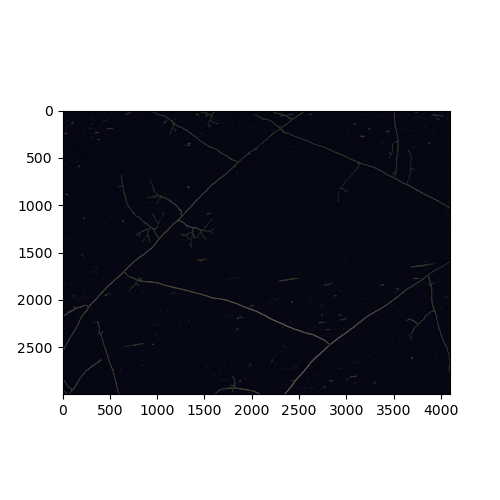

In [49]:
low = 20
high = 90
# transformed = -img+255
transformed = im2

hyst = filters.apply_hysteresis_threshold(transformed, low, high)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.imshow(im2, cmap="gray")
ax.imshow(hyst, alpha=0.1, cmap="jet")

In [50]:
kernel = np.ones((3, 3), np.uint8)
dilation = cv.dilate(hyst.astype(np.uint8) * 255, kernel, iterations=1)
for i in range(3):
    dilation = cv.erode(dilation.astype(np.uint8) * 255, kernel, iterations=1)
    dilation = cv.dilate(dilation.astype(np.uint8) * 255, kernel, iterations=1)
dilated = dilation > 0
nb_components, output, stats, centroids = cv.connectedComponentsWithStats(
    dilated.astype(np.uint8), connectivity=8
)
# connectedComponentswithStats yields every seperated component with information on each of them, such as size
# the following part is just taking out the background which is also considered a component, but most of the time we don't want that.
sizes = stats[1:, -1]
nb_components = nb_components - 1

# minimum size of particles we want to keep (number of pixels)
# here, it's a fixed value, but you can set it as you want, eg the mean of the sizes or whatever
min_size = 4000

# your answer image
img_f = np.zeros((dilated.shape))
# for every component in the image, you keep it only if it's above min_size
for i in range(0, nb_components):
    if sizes[i] >= min_size:
        img_f[output == i + 1] = 1
skeletonized = cv.ximgproc.thinning(np.array(255 * img_f, dtype=np.uint8))

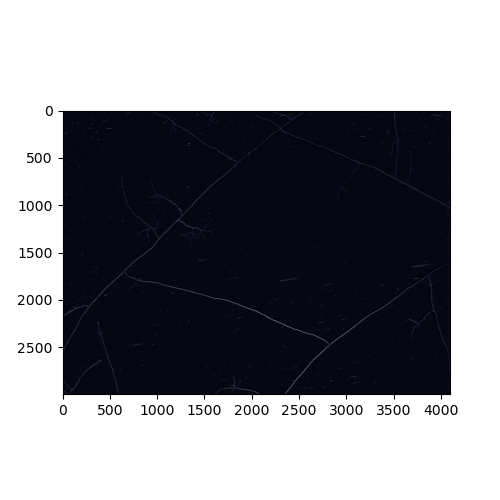

In [51]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.imshow(im2, cmap="gray")
ax.imshow(skeletonized, cmap="jet", alpha=0.1)

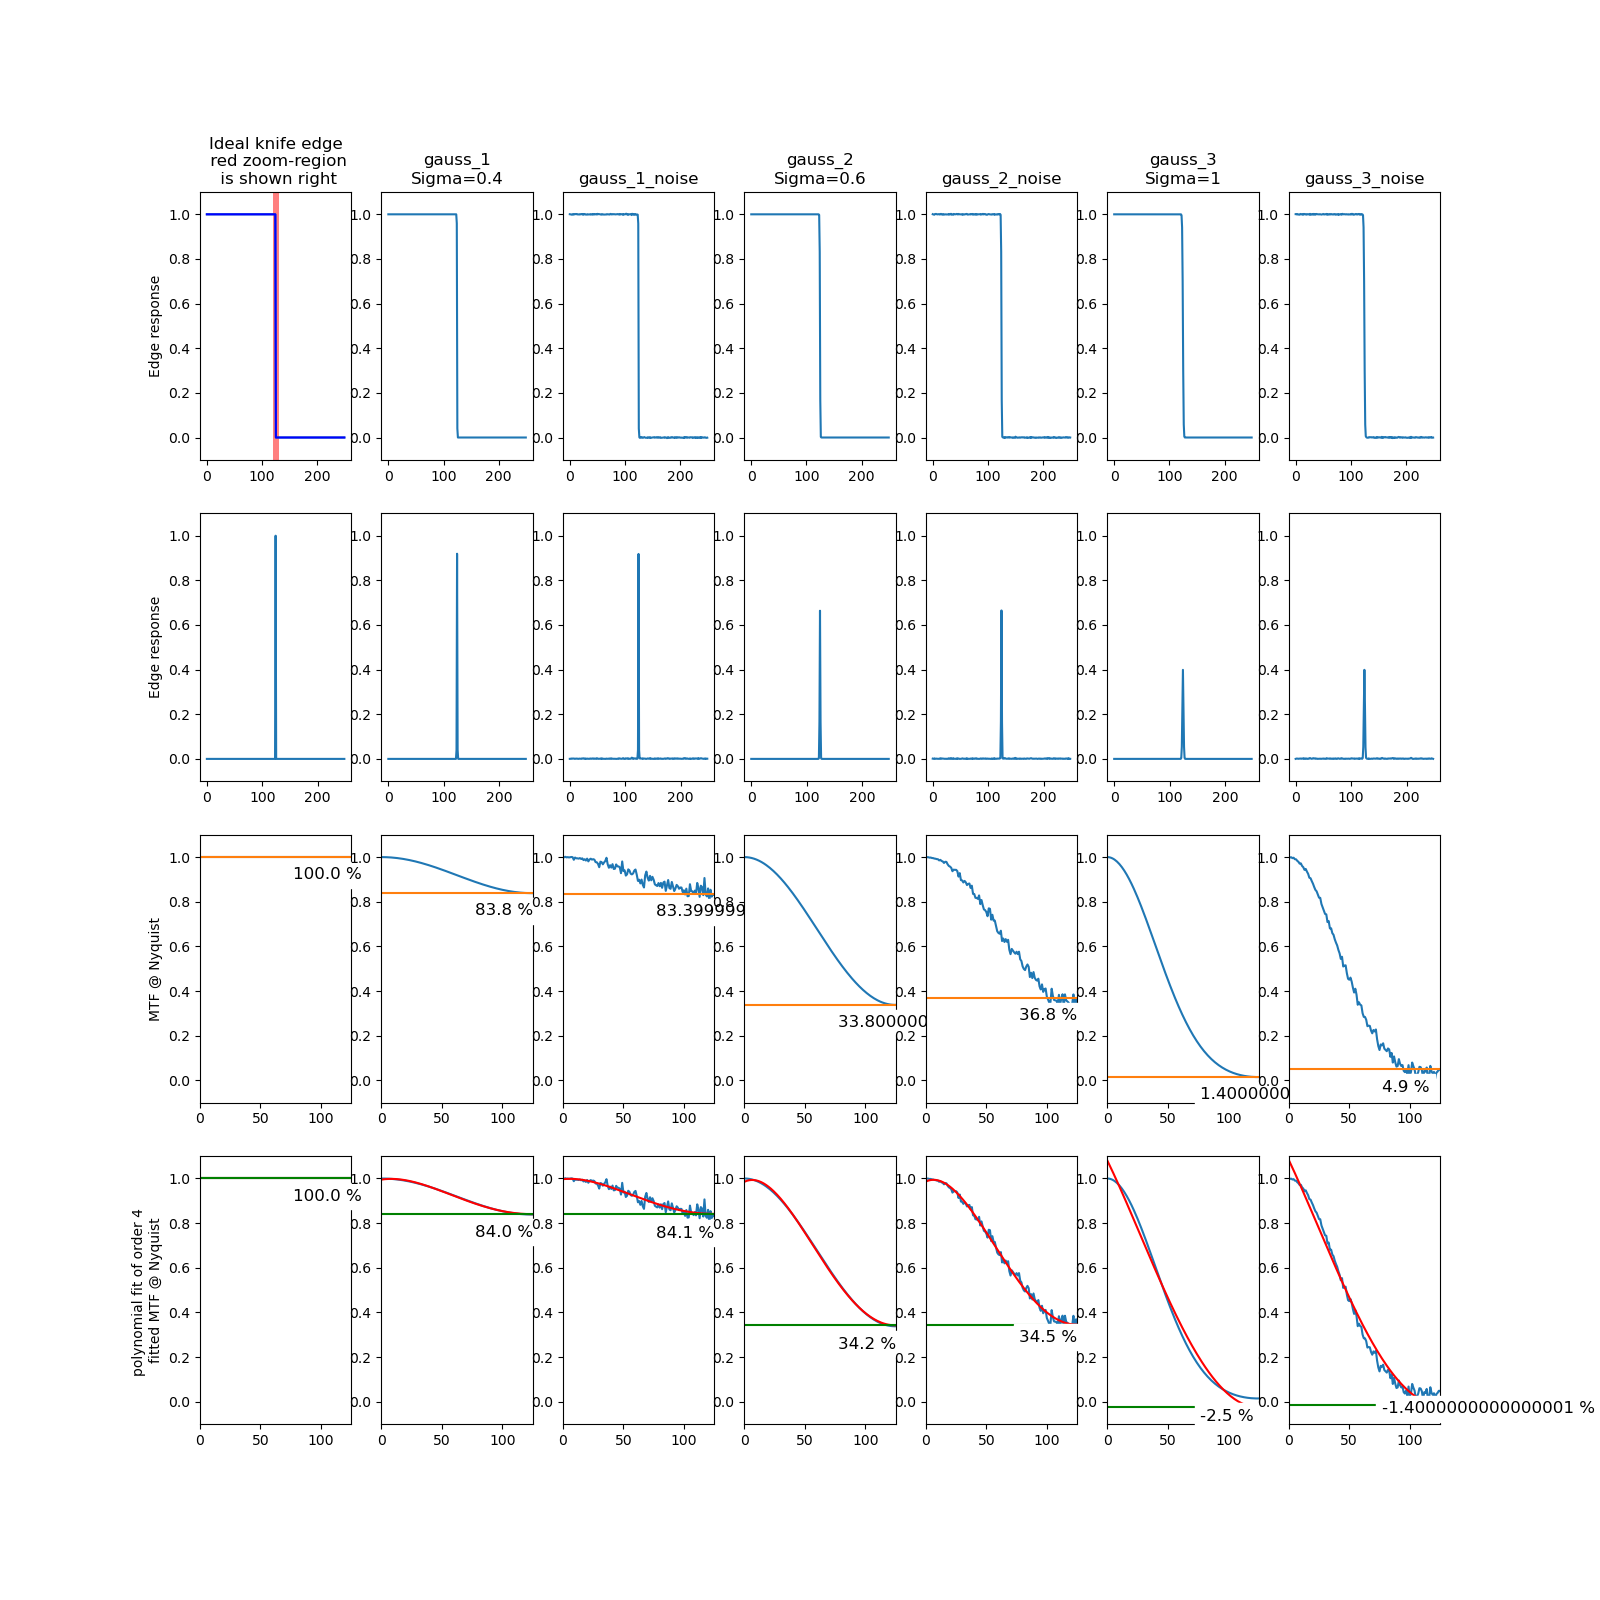

In [40]:
import numpy as np
import scipy
import scipy.ndimage
import matplotlib.pylab as plt
import time


def MTF(edgespreadfunction):
    """
    Compute the modulation transfer function (MTF).
    The MTF is defined as the FFT of the line spread function.
    The line spread function is defined as the derivative of the edge spread
    function. The edge spread function are the values along an edge, ideally a
    knife-edge test target. See an explanation here: http://is.gd/uSC5Ve
    """
    linespreadfunction = np.diff(edgespreadfunction)
    return np.abs(np.fft.fft(linespreadfunction))


def LSF(edgespreadfunction):
    """
    Compute the modulation transfer function (MTF).
    The MTF is defined as the FFT of the line spread function.
    The line spread function is defined as the derivative of the edge spread
    function. The edge spread function are the values along an edge, ideally a
    knife-edge test target. See an explanation here: http://is.gd/uSC5Ve
    """
    return np.abs(np.diff(edgespreadfunction))


def polynomialfit(data, order):
    """
    calculate the polynomial fit of an input for a defined degree
    """
    x, y = range(len(data)), data
    coefficients = np.polyfit(x, y, order)
    return np.polyval(coefficients, x)


# Generate edge for N points
N = 250
dirac = np.zeros(N)
dirac[: N // 2] = 1

# Filter edge
sigma = [0.4, 0.6, 1]
gauss_1 = scipy.ndimage.gaussian_filter(dirac, sigma=sigma[0])
gauss_2 = scipy.ndimage.gaussian_filter(dirac, sigma=sigma[1])
gauss_3 = scipy.ndimage.gaussian_filter(dirac, sigma=sigma[2])

SaveFigure = False
# Total = 55
# for iteration in range(Total):
#     print 'Plotting', iteration, 'of', Total

noise_sigma = 0.001
gauss_1_noise = gauss_1 + noise_sigma * np.random.randn(len(dirac))
gauss_2_noise = gauss_2 + noise_sigma * np.random.randn(len(dirac))
gauss_3_noise = gauss_3 + noise_sigma * np.random.randn(len(dirac))


"""
Save the plots in a dictionary, so we can iterate through it afterwards. See
http://stackoverflow.com/a/2553532/323100 and http://is.gd/d008ai for reference
"""
plots = dict(
    (name, eval(name))
    for name in [
        "dirac",
        "gauss_1",
        "gauss_1_noise",
        "gauss_2",
        "gauss_2_noise",
        "gauss_3",
        "gauss_3_noise",
    ]
)

plt.figure(figsize=(16, 16))
counter = 0
ShowRegion = 10
for name, data in sorted(plots.items()):
    counter += 1
    plt.subplot(4, len(plots), counter)
    plt.plot(data)
    plt.ylim(-0.1, 1.1)
    # plt.xlim(len(dirac) / 2 - ShowRegion / 2, len(dirac) / 2 + ShowRegion /
    #          2)
    if name == "dirac":
        plt.ylabel("Edge response")
    plt.title(name)
    if name == "gauss_1":
        plt.title(name + "\nSigma=" + str(sigma[0]))
    if name == "gauss_2":
        plt.title(name + "\nSigma=" + str(sigma[1]))
    if name == "gauss_3":
        plt.title(name + "\nSigma=" + str(sigma[2]))

    plt.subplot(4, len(plots), counter + len(plots))
    plt.plot(LSF(data))
    plt.ylim(-0.1, 1.1)
    if name == "dirac":
        plt.ylabel("Edge response")

    plt.subplot(4, len(plots), counter + 2 * len(plots))
    plt.plot(MTF(data))
    plt.plot(np.ones(N) * MTF(data)[len(dirac) // 2])
    plt.ylim(-0.1, 1.1)
    plt.xlim(0, len(dirac) // 2)
    if name == "dirac":
        plt.ylabel("MTF @ Nyquist")
    plt.text(
        0.618 * len(dirac) // 2,
        MTF(data)[len(dirac) // 2] - 0.1,
        " ".join([str(np.round(MTF(data)[len(dirac) // 2], 3) * 100), "%"]),
        fontsize=12,
        backgroundcolor="w",
    )

    plt.subplot(4, len(plots), counter + 3 * len(plots))
    plt.plot(MTF(data), label="orig")
    # for degree in range(10,25):
    #     plt.plot(polynomialfit(MTF(data), degree), label=str(degree))
    # plt.legend()
    degree = 4
    plt.plot(polynomialfit(MTF(data), degree), label=str(degree), color="r")
    plt.plot(np.ones(N) * polynomialfit(MTF(data), degree)[len(dirac) // 2], color="g")
    plt.ylim(-0.1, 1.1)
    plt.xlim(0, len(dirac) // 2)
    if name == "dirac":
        plt.ylabel(
            " ".join(["polynomial fit of order", str(degree), "\nfitted MTF @ Nyquist"])
        )
    plt.text(
        0.618 * len(dirac) // 2,
        MTF(data)[len(dirac) // 2] - 0.1,
        " ".join(
            [
                str(
                    np.round(polynomialfit(MTF(data), degree)[len(dirac) // 2], 3) * 100
                ),
                "%",
            ]
        ),
        fontsize=12,
        backgroundcolor="w",
    )

plt.subplot(4, len(plots), 1)
plt.plot(dirac, "b")
plt.ylim(-0.1, 1.1)
plt.axvspan(
    len(dirac) // 2 - ShowRegion // 2,
    len(dirac) // 2 + ShowRegion // 2,
    facecolor="r",
    alpha=0.5,
)
plt.title("Ideal knife edge\n red zoom-region\n is shown right")

if SaveFigure:
    plt.savefig("MTF_" + str(int(time.time() * 10)) + ".png")
else:
    plt.show()